# Lab 6: Kernel Methods
Support Vector Machines are powerful methods, but they also require careful tuning. We'll explore SVM kernels and hyperparameters on an artificial dataset. We'll especially look at model underfitting and overfitting.

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import random
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold    
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score   

from print_versions import print_versions
print_versions(globals())

import sys
print(sys.version)
import warnings
warnings.filterwarnings('ignore')

sklearn==1.3.2
numpy==1.24.4
pandas==2.0.3
openml==0.14.2
3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]


## Getting the data
We fetch the Banana data from OpenML: https://www.openml.org/d/1460  

In [2]:
bananas = oml.datasets.get_dataset(1460) # Banana data has OpenML ID 1460
X, y, _, _ = bananas.get_data(target=bananas.default_target_attribute, dataset_format='array');

Quick look at the data:

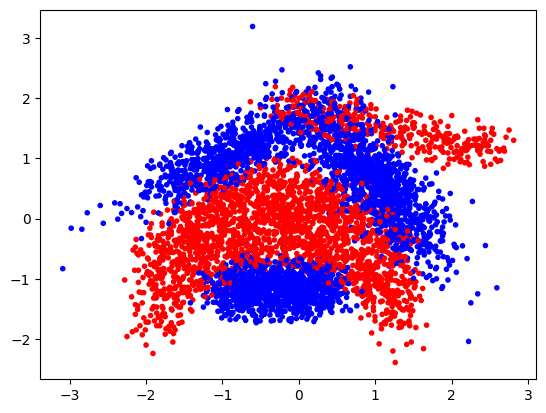

In [3]:
plt.scatter(X[:,0], X[:,1], c=y,cmap=plt.cm.bwr, marker='.');

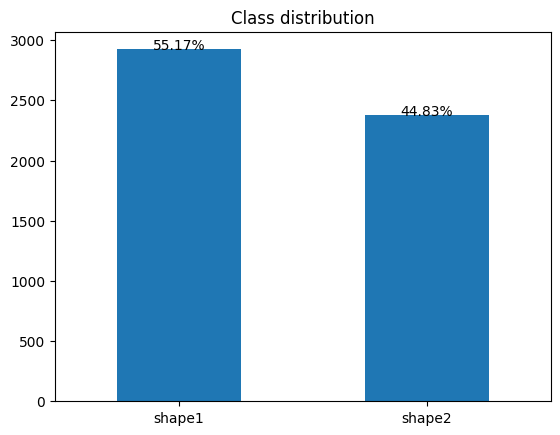

In [4]:
pd.Series(y).value_counts().plot(kind='bar', title='Class distribution')
# add percentages above bars
for i, v in enumerate(pd.Series(y).value_counts()):
    plt.text(i, v + 0.02, str(round(v/len(y)*100, 2)) + "%", ha='center')
    
# change the xtickslabels to "shape1", and "shape2"
plt.xticks([0, 1], ["shape1", "shape2"], rotation=0)

plt.show()

In [5]:
# Plotting helpers. Based loosely on https://github.com/amueller/mglearn
def plot_svm_kernel(X, y, title, support_vectors, decision_function, ax, dual_coef=None, show=True):
    """
    Visualizes the SVM model given the various outputs. It plots:
    * All the data point, color coded by class: blue or red
    * The support vectors, indicated by circling the points with a black border.
      If the dual coefficients are known (only for kernel SVMs) if paints support vectors with high coefficients darker
    * The decision function as a blue-to-red gradient. It is white where the decision function is near 0.
    * The decision boundary as a full line, and the SVM margins (-1 and +1 values) as a dashed line

    Attributes:
    X -- The training data
    y -- The correct labels
    title -- The plot title
    support_vectors -- the list of the coordinates of the support vectores
    decision_function - The decision function returned by the SVM
    dual_coef -- The dual coefficients of all the support vectors (not relevant for LinearSVM)
    show -- whether to plot the figure already or not
    """
    # plot the line, the points, and the nearest vectors to the plane
    #plt.figure(fignum, figsize=(5, 5))
    ax.set_title(title)
    ax.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr, marker='.')
    if dual_coef is not None:
        ax.scatter(support_vectors[:, 0], support_vectors[:, 1], c=dual_coef[0, :],
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    else:
        ax.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    # ax.set_axis('tight')
    x_min, x_max = -3.5, 3.5
    y_min, y_max = -3.5, 3.5

    XX, YY = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
    Z = decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])
    ax.pcolormesh(XX, YY, Z, vmin=-1, vmax=1, cmap=plt.cm.bwr, alpha=0.1)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.set_xticks(())
    ax.set_yticks(())

    if show:
        plt.show()

def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    """
    Visualizes the results of a grid search with two hyperparameters as a heatmap.
    Attributes:
    values -- The test scores
    xlabel -- The name of hyperparameter 1
    ylabel -- The name of hyperparameter 2
    xticklabels -- The values of hyperparameter 1
    yticklabels -- The values of hyperparameter 2
    cmap -- The matplotlib color map
    vmin -- the minimum value
    vmax -- the maximum value
    ax -- The figure axes to plot on
    fmt -- formatting of the score values
    """
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

## Exercise 1: Linear SVMs

First, we'll look at linear SVMs and the different outputs they produce. Check the [documentation of LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

The most important inputs are:  
* C -- The C hyperparameter controls the misclassification cost and therefore the amount of regularization. Lower values correspond to more regularization
* loss - The loss function, typically 'hinge' or 'squared_hinge'. Squared hinge is the default. Normal hinge is less strict.
* dual -- Whether to solve the primal optimization problem or the dual (default). The primal is recommended if you have many more data points than features (although our datasets is very small, so it won't matter much).

The most important outputs are:  
* decision_function - The function used to classify any point. In this case on linear SVMs, this corresponds to the learned hyperplane, or $y = \mathbf{wX} + b$. It can be evaluated at every point, if the result is positive the point is classified as the positive class and vice versa.
* coef_ - The model coefficients, i.e. the weights $\mathbf{w}$
* intercept_ - the bias $b$

From the decision function we can find which points are support vectors and which are not: the support vectors are all
the points that fall inside the margin, i.e. have a decision value between -1 and 1, or that are misclassified. Also see the lecture slides.

### Exercise 1.1: Linear SVMs
Train a LinearSVC with C=0.001 and hinge loss. Then, use the plotting function `plot_svm_kernel` to plot the results. For this you need to extract the support vectors from the decision function. There is a hint below should you get stuck.
Interpret the plot as detailed as you can. Afterwards you can also try some different settings. You can also try using the primal instead of the dual optimization problem (in that case, use squared hinge loss).

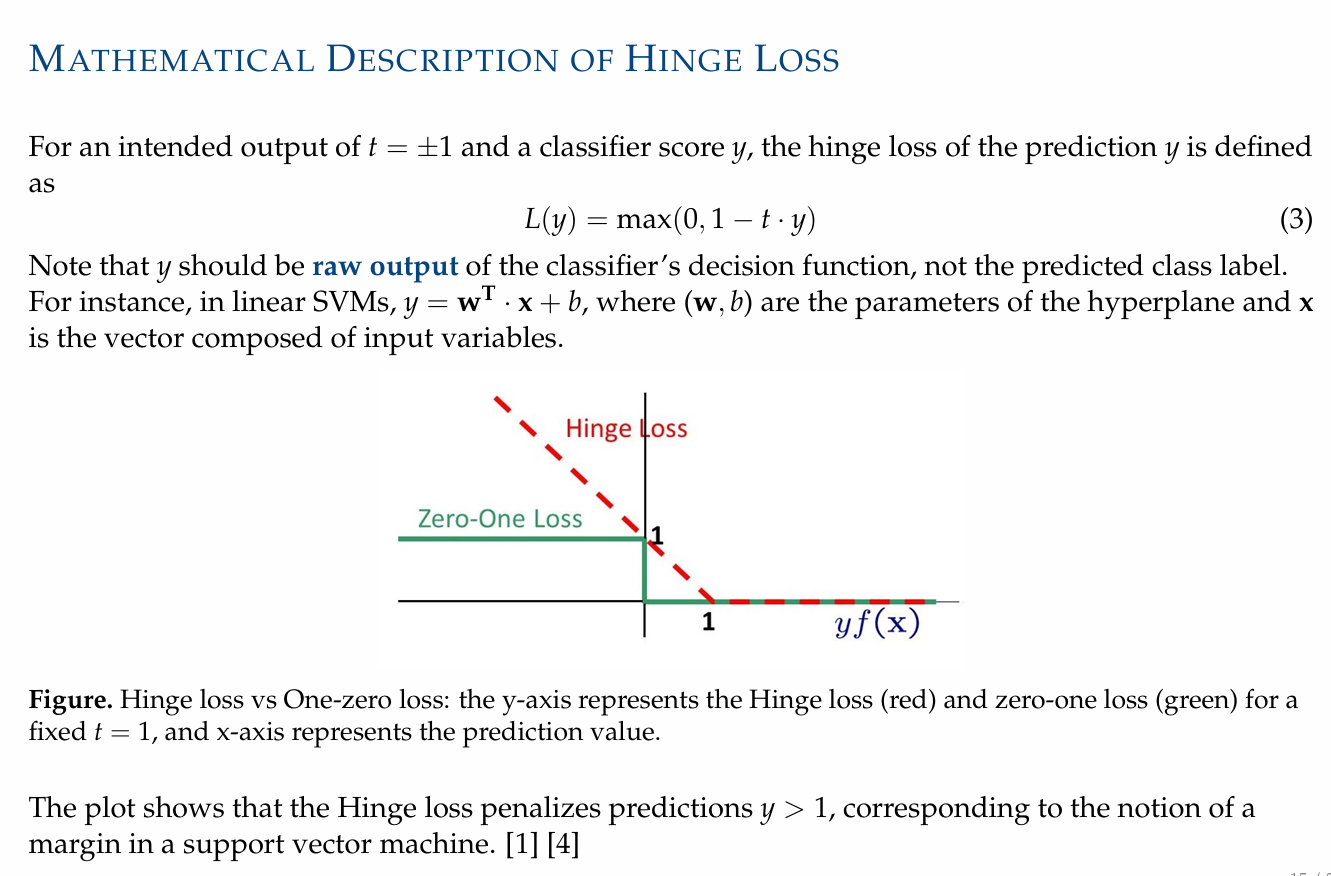

In [6]:
def hinge_loss_support_vector_indices_function(y_true, y_pred, threshold=0):
    """
    Returns the indices of the support vectors for which the hinge loss is below a certain threshold.
    Attributes:
    y_true -- The true labels
    y_pred -- The predicted labels
    threshold -- The threshold for the hinge loss
    """
    loss = np.maximum(0, 1 - y_true * y_pred)
    return np.where(loss <= threshold)[0]

def squared_hinge_loss_support_vector_indices_function(y_true, y_pred, threshold=0):
    """
    Returns the indices of the support vectors for which the squared hinge loss is below a certain threshold.
    Attributes:
    y_true -- The true labels
    y_pred -- The predicted labels
    threshold -- The threshold for the squared hinge loss
    """
    loss = np.maximum(0, 1 - y_true * y_pred) ** 2
    return np.where(loss <= threshold)[0]

def get_linear_svc_model(X, y, C, loss, dual, support_vectors_indices_function):
    """
    Trains a linear SVM model with the given hyperparameters and returns the model and the support vectors
    Attributes:
    X -- The training data
    y -- The correct labels
    C -- The regularization parameter
    loss -- The loss function
    dual -- Whether to use the dual formulation or not
    support_vectors_indices_function -- The function to calculate the support vectors
    """
    clf = LinearSVC(C=C, loss=loss, dual=dual)
    clf.fit(X, y)
    support_vector_indices = support_vectors_indices_function(y, clf.decision_function(X))
    support_vectors = X[support_vector_indices]
    return clf, support_vectors


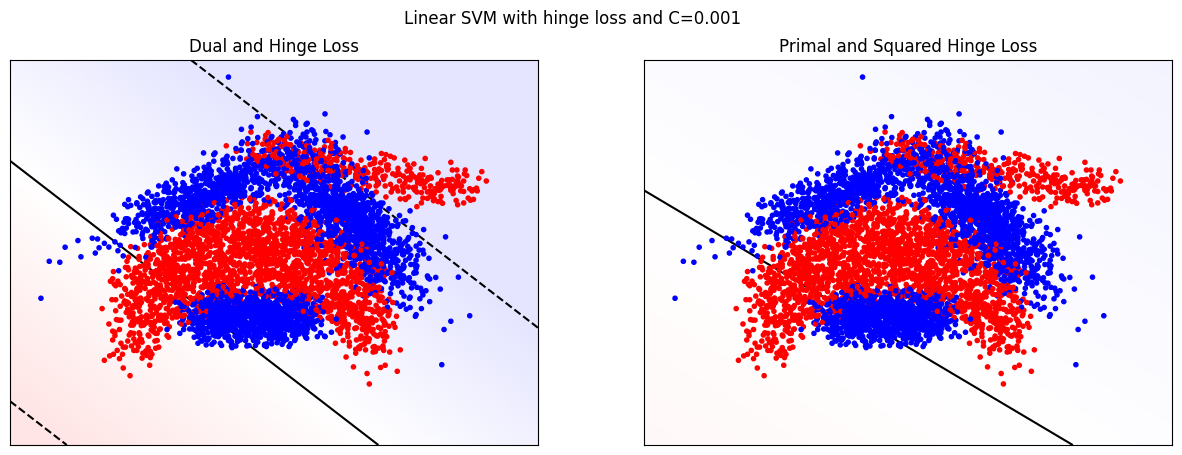

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Linear SVC dual, hinge loss, and C=0.001
clf, support_vectors = get_linear_svc_model(X, y, 0.001, 'hinge', True, hinge_loss_support_vector_indices_function)
plot_svm_kernel(X, y, "Dual and Hinge Loss", support_vectors, clf.decision_function, axes[0], show=False)

# Linear SVC primal, hinge loss, and C=0.001
clf, support_vectors = get_linear_svc_model(X, y, 0.001, 'squared_hinge', False, squared_hinge_loss_support_vector_indices_function )
plot_svm_kernel(X, y, "Primal and Squared Hinge Loss", support_vectors, clf.decision_function, axes[1], show=False)

plt.suptitle("Linear SVM with hinge loss and C=0.001")
plt.show()

- **Interpret the plot as detailed as you can.**


- On the first subplot, we have the linear SVC decision function to distinguish obtained by solving the dual problem and using the hinge loss.

    + The function obatained doesn't help to clearly distinguish between both shapes of bananas.
    + And as we used a small value of `C`, the margines are very wide.

- On the second, we have another decision function obtained by solving the primal and using the squared hinge loss.

    + Also in this case, the separation line has a poor accuracy
    + The margins don't appear. We can assume that they are too wide.
    + As we have more observations than feautres(**only two**), this could explain partly why the accuracy is too poor

- Also, using a linear kernel in this case doesn't appear suitable, because the data aren't linearly separable.

## Exercise 2: Kernelized SVMs

Check the [documentation of SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

It has a few more inputs. The most important:
* kernel - It must be either ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, or your custom defined kernel.
* gamma - The kernel width of the `rbf` (Gaussian) kernel. Smaller values mean wider kernels.
          Only relevant when selecting the rbf kernel.
* degree - The degree of the polynomial kernel. Only relevant when selecting the poly kernel.

There also also more outputs that make our lifes easier:  
* support_vectors_ - The array of support vectors
* n_support_ - The number of support vectors per class
* dual_coef_ - The coefficients of the support vectors (the dual coefficients)

### Exercise 2.1

Evaluate different kernels, with their default hyperparameter settings.
Outputs should be the 5-fold cross validated accuracy scores for the linear kernel (lin_scores), polynomial kernel (poly_scores) and RBF kernel (rbf_scores). Print the mean and variance of the scores and give an initial interpretation of the performance of each kernel.

In [8]:
def get_svc_cv_results(X, y, C, kernel, gamma, cv):
    """
    Trains a SVM model with the given hyperparameters and returns the cross-validation results
    Attributes:
    X -- The training data
    y -- The correct labels
    C -- The regularization parameter
    kernel -- The kernel function
    gamma -- The gamma parameter
    cv -- The cross-validation strategy
    """
    clf = SVC(C=C, kernel=kernel, gamma=gamma)
    results = cross_validate(clf, X, y, cv=cv, return_train_score=True, scoring='accuracy')
    return results

In [9]:
# get results in dataframe
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=45) #StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_linear = get_svc_cv_results(X, y, 1, 'linear', 'auto', cv)
results_rbf = get_svc_cv_results(X, y, 1, 'rbf', 'auto', cv)
results_poly = get_svc_cv_results(X, y, 1, 'poly', 'auto', cv)
results_sigmoid = get_svc_cv_results(X, y, 1, 'sigmoid', 'auto', cv)

# Dataframe with the results mean and standard deviation of each model
results = pd.DataFrame({
    'Linear': [results_linear['train_score'].mean(), results_linear['train_score'].std(), 
               results_linear['test_score'].mean(), results_linear['test_score'].std()],
    'RBF': [results_rbf['train_score'].mean(), results_rbf['train_score'].std(),
            results_rbf['test_score'].mean(), results_rbf['test_score'].std()],
    'Poly': [results_poly['train_score'].mean(), results_poly['train_score'].std(),
             results_poly['test_score'].mean(), results_poly['test_score'].std()],
    'Sigmoid': [results_sigmoid['train_score'].mean(), results_sigmoid['train_score'].std(),
                results_sigmoid['test_score'].mean(), results_sigmoid['test_score'].std()]
}, index=['Train mean', 'Train std', 'Test mean', 'Test std'])

# add multi index to the columns from ["Train Score", "Test Score"] and ["Mean", "Std"]
results.index = pd.MultiIndex.from_product([['Train Score', 'Test Score'], ['Mean', 'Std']],
                                             names=['', ''])

# color columns or rows with the best results
def highlight_best(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

results = results.style.apply(highlight_best, axis=1)
results

## Exercise 2: Visualizing the fit
To better understand what the different kernels are doing, let's visualize their predictions.

### Exercise 2.1
Call and fit SVM with linear, polynomial and RBF kernels with default parameter values. For RBF kernel, use kernel coefficient value (gamma) of 2.0. Plot the results for each kernel with "plot_svm_kernel" function. The plots show the predictions made for the different kernels. The background color shows the prediction (blue or red). The full line shows the decision boundary, and the dashed line the margin. The encircled points are the support vectors.

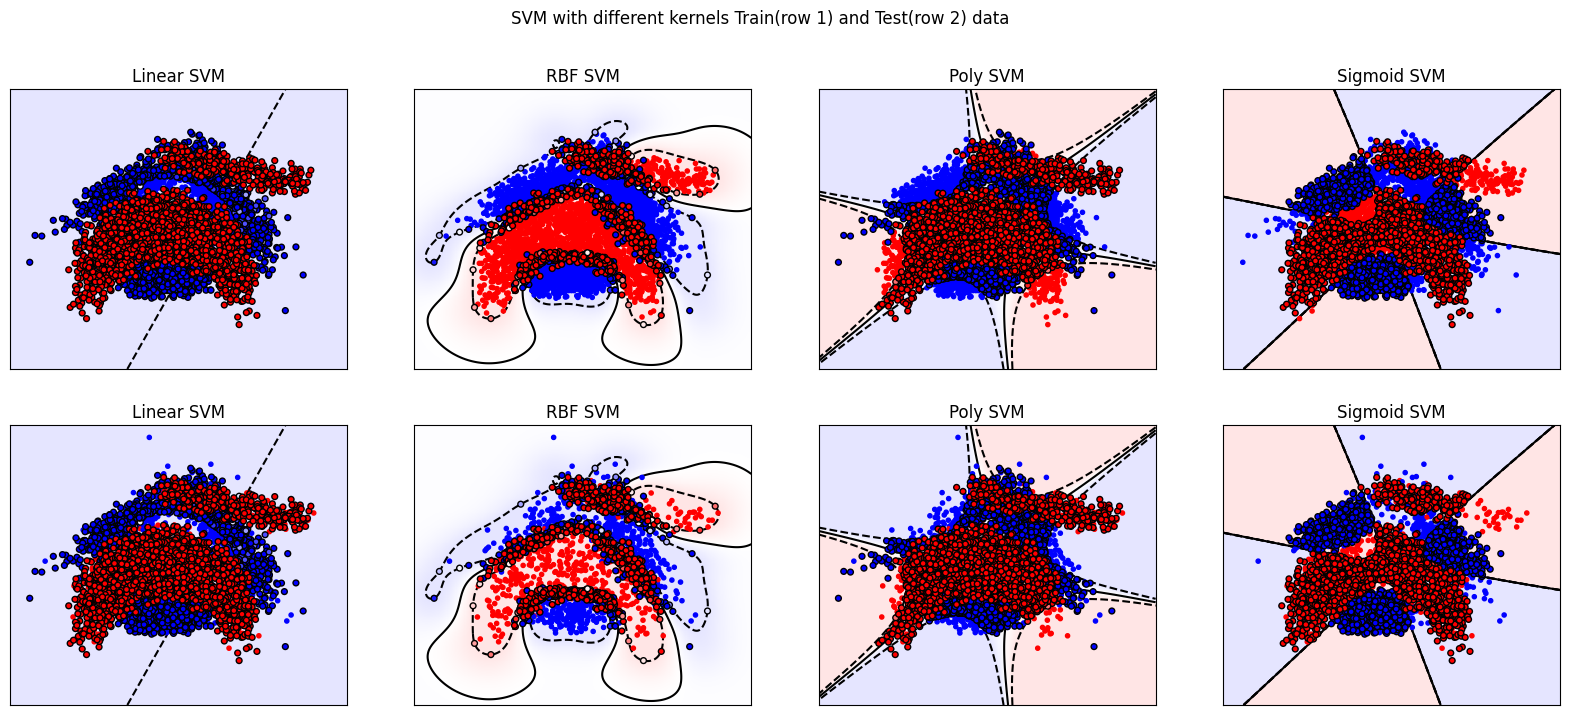

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size=0.8)

# Linear SVM
clf = SVC(C=1, kernel='linear', gamma='auto')
clf.fit(X_train, y_train)
plot_svm_kernel(X_test, y_test, "Linear SVM", clf.support_vectors_, clf.decision_function, axes[1][0], show=False, dual_coef=clf.dual_coef_)
plot_svm_kernel(X_train, y_train, "Linear SVM", clf.support_vectors_, clf.decision_function, axes[0][0], show=False, dual_coef=clf.dual_coef_)
# RBF SVM
clf = SVC(C=1, kernel='rbf', gamma=2)
clf.fit(X_train, y_train)
plot_svm_kernel(X_test, y_test, "RBF SVM", clf.support_vectors_, clf.decision_function, axes[1][1], show=False, dual_coef=clf.dual_coef_)
plot_svm_kernel(X_train, y_train, "RBF SVM", clf.support_vectors_, clf.decision_function, axes[0][1], show=False, dual_coef=clf.dual_coef_)

# Poly SVM
clf = SVC(C=1, kernel='poly', gamma=1)
clf.fit(X_train, y_train)
plot_svm_kernel(X_test, y_test, "Poly SVM", clf.support_vectors_, clf.decision_function, axes[1][2], show=False, dual_coef=clf.dual_coef_)
plot_svm_kernel(X_train, y_train, "Poly SVM", clf.support_vectors_, clf.decision_function, axes[0][2], show=False, dual_coef=clf.dual_coef_)

# Sigmoid SVM
clf = SVC(C=1, kernel='sigmoid', gamma=1)
clf.fit(X_train, y_train)
plot_svm_kernel(X_test, y_test, "Sigmoid SVM", clf.support_vectors_, clf.decision_function, axes[1][3], show=False, dual_coef=clf.dual_coef_)
plot_svm_kernel(X_train, y_train, "Sigmoid SVM", clf.support_vectors_, clf.decision_function, axes[0][3], show=False, dual_coef=clf.dual_coef_)

plt.suptitle("SVM with different kernels Train(row 1) and Test(row 2) data")
plt.show()

### Exercise 2.2
Interpret the plots for each kernel. Think of ways to improve the results.

- On the **linear kernel** plot, the separation line doesn't clearly separate both sapes of bananas
- On the **rbf kernel** plot, the separation line is accurate and succeed to distinguish between both shapes of bananas
- On the **poly kernel** plot, the separation line tries to separate shapes of bananas on the borders but misclassify those at the center of the distribution,
- Using a **sigmoid kernel**, leads to separation regions with lot of misclassifications.

- The **Linear kernel**, **Sigmoid kernel**, and **poly** kernel are underfitting to the data, whereas the **rbf kernel** is just fitting: We can improve the two first kernels using some feature engineering(like polar coordinates), the third one by adding complexity to the model(increasing the polynomial degree), and the last one by tuning the value of `gamma`.

## Exercise 3: Visualizing the RBF models and hyperparameter space
Select the RBF kernel and optimize the two most important hyperparameters (the 𝐶 parameter and the kernel width 𝛾 ).

Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale.

### Exercise 3.1
First try 3 very different values for $C$ and $\gamma$ (for instance [1e-3,1,1e3]). For each of the 9 combinations, create the same RBF plot as before to understand what the model is doing. Also create a standard train-test split and report the train and test score. Explain the performance results. When are you over/underfitting? Can you see this in the predictions?

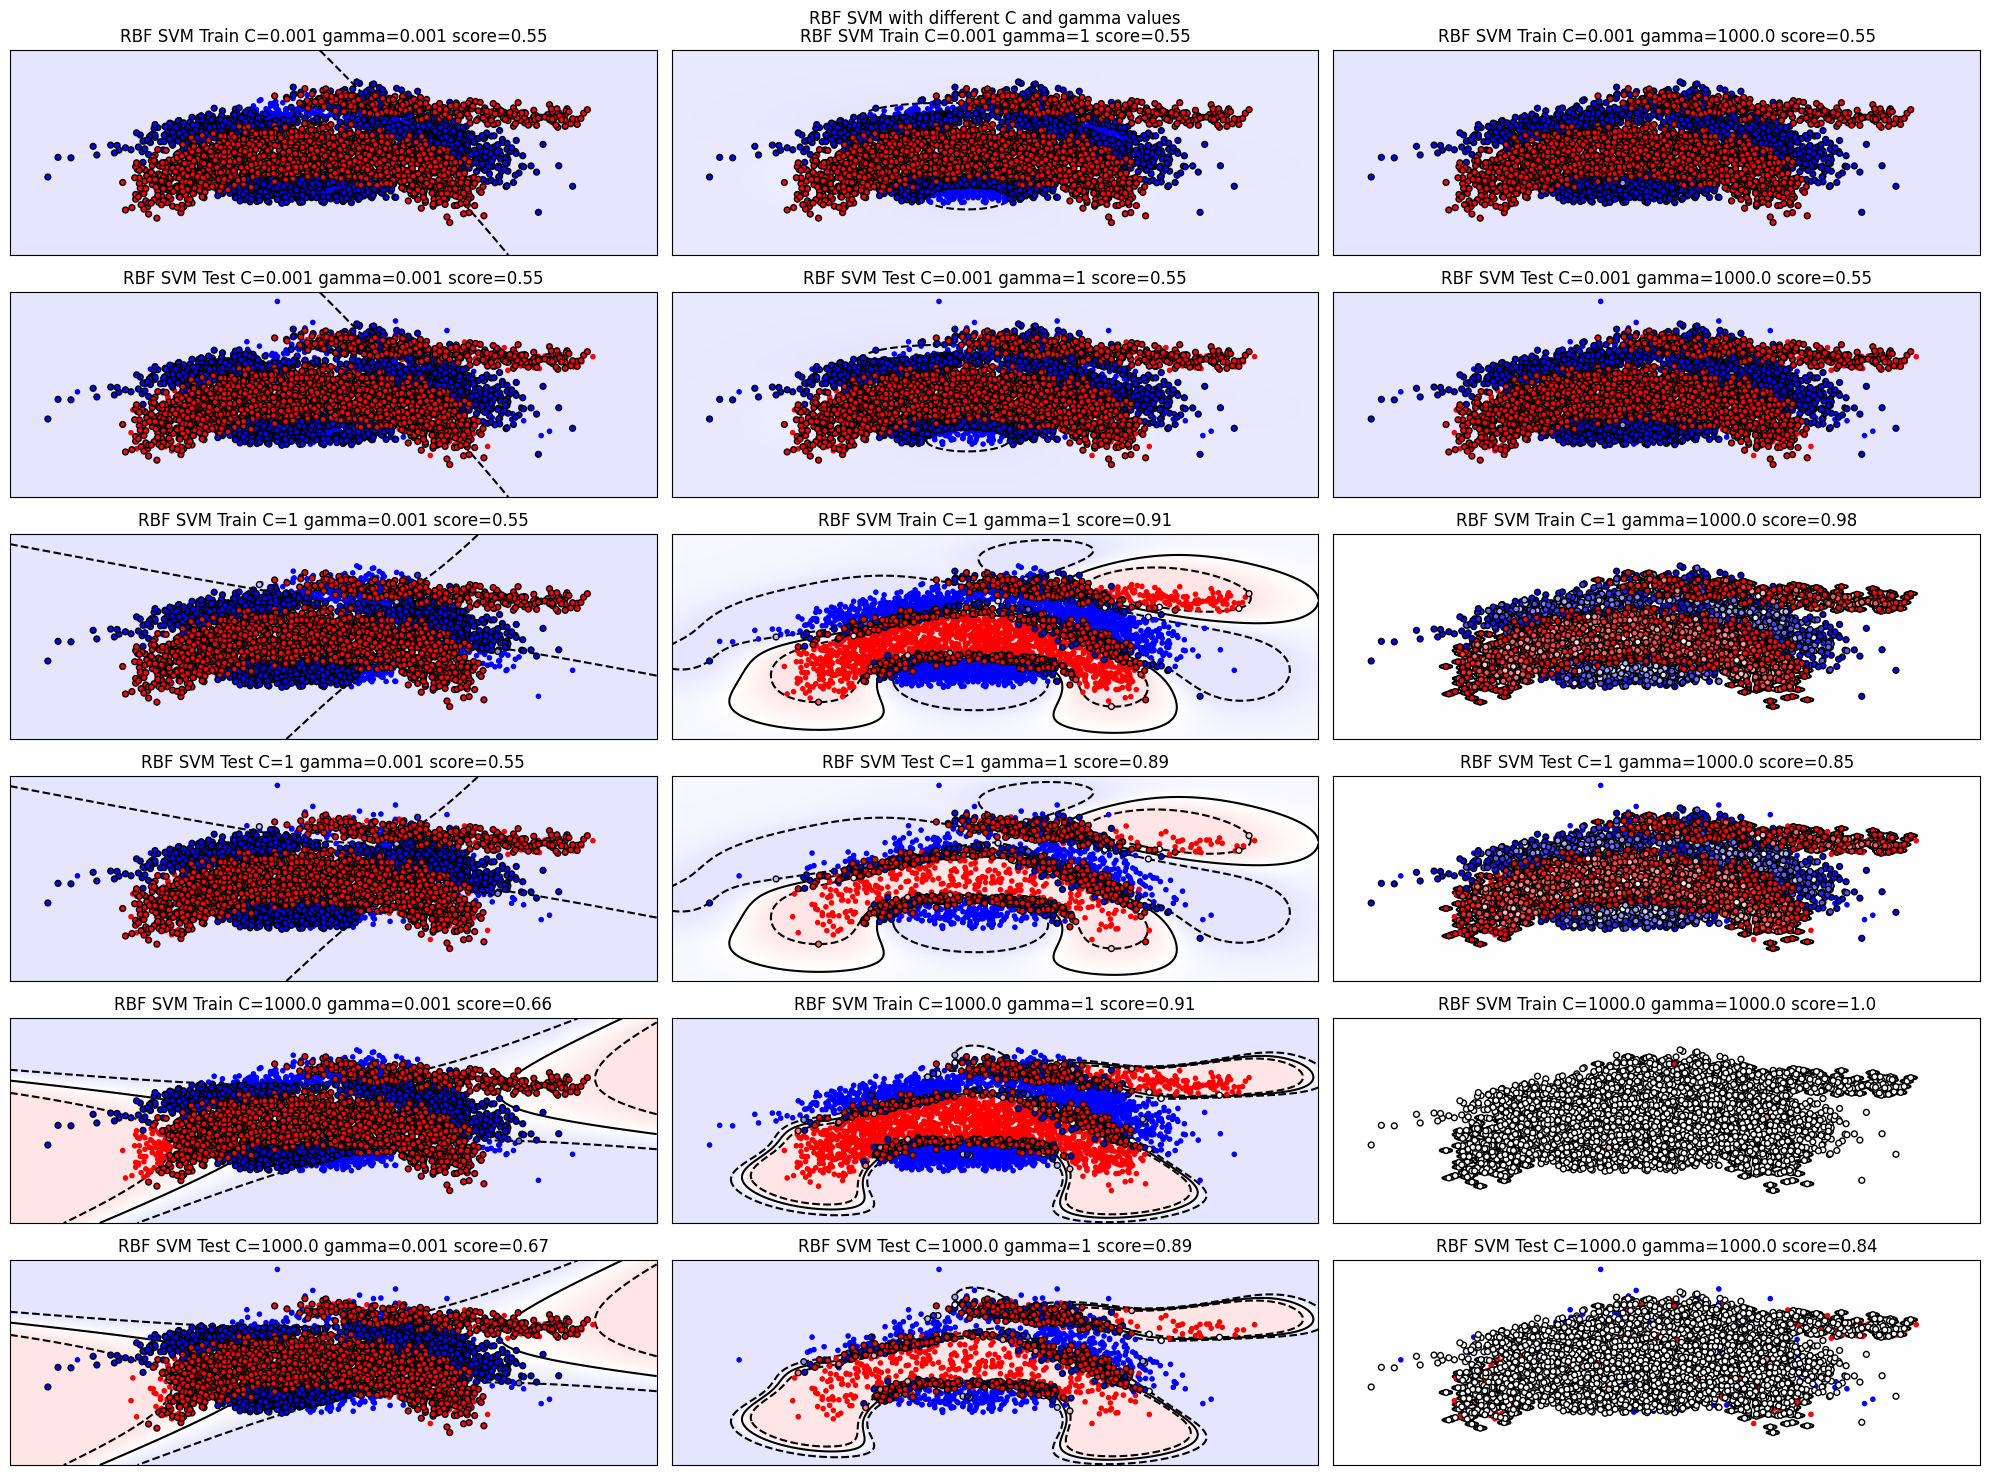

In [11]:
results_rbf_df = pd.DataFrame()
fig, axes = plt.subplots(6, 3, figsize=(20, 15))
for i, C in enumerate([1e-3, 1, 1e3]):
    for j, gamma in enumerate([1e-3, 1, 1e3]):
        clf = SVC(C=C, kernel='rbf', gamma=gamma)
        clf.fit(X_train, y_train)
        # add the train_score, test_score, and the confusion matrix to the dataframe
        results_rbf_df = pd.concat([results_rbf_df, 
                                    pd.DataFrame({
            'C': C,
            'gamma': gamma,
            'train_score': clf.score(X_train, y_train),
            'test_score': clf.score(X_test, y_test),
            'confusion_matrix_tp': confusion_matrix(y_test, clf.predict(X_test))[0][0],
            'confusion_matrix_fp': confusion_matrix(y_test, clf.predict(X_test))[0][1],
            'confusion_matrix_fn': confusion_matrix(y_test, clf.predict(X_test))[1][0],
            'confusion_matrix_tn': confusion_matrix(y_test, clf.predict(X_test))[1][1]
        },
                                                 # add index to dataframe
                                                 index=[f"C={C} gamma={gamma}"]
                                                 )], axis=0)
        
        # plot svm models for train and test data
        plot_svm_kernel(X_train, y_train, f"RBF SVM Train C={C} gamma={gamma} score={round(clf.score(X_train, y_train), 2)}", 
                        clf.support_vectors_, clf.decision_function, axes[i*2][j], show=False, dual_coef=clf.dual_coef_)
        plot_svm_kernel(X_test, y_test, f"RBF SVM Test C={C} gamma={gamma} score={round(clf.score(X_test, y_test), 2)}",
                        clf.support_vectors_, clf.decision_function, axes[i*2+1][j], show=False, dual_coef=clf.dual_coef_)

plt.suptitle("RBF SVM with different C and gamma values")
plt.tight_layout()
plt.show()

In [12]:
# style the dataframe
results_rbf_df.style.apply(highlight_best, axis=0)

,C,gamma,train_score,test_score,confusion_matrix_tp,confusion_matrix_fp,confusion_matrix_fn,confusion_matrix_tn
C=0.001 gamma=0.001,0.001000,0.001000,0.551651,0.551887,585,0,475,0
C=0.001 gamma=1,0.001000,1.000000,0.551651,0.551887,585,0,475,0
C=0.001 gamma=1000.0,0.001000,1000.000000,0.551651,0.551887,585,0,475,0
C=1 gamma=0.001,1.000000,0.001000,0.551651,0.551887,585,0,475,0
C=1 gamma=1,1.000000,1.000000,0.911557,0.889623,552,33,84,391
C=1 gamma=1000.0,1.000000,1000.000000,0.979009,0.848113,520,65,96,379
C=1000.0 gamma=0.001,1000.000000,0.001000,0.658255,0.670755,560,25,324,151
C=1000.0 gamma=1,1000.000000,1.000000,0.912028,0.887736,553,32,87,388
C=1000.0 gamma=1000.0,1000.000000,1000.000000,1.000000,0.843396,515,70,96,379


- **Explain the performance results.**

    + For **gamma=0.001**, the accuracy score is less than 68% for any values of C. No matter how we reduce or wider the separation margins, the low value of gamma doesn't allow to go in a higher enough dimension space where the bananas shapes are distinguishables. 
    The model also produces a lot of false negatives when C=1000.

    + For **gamma=1**, 
        - The model has a low score on test set for C=0.001: we can explain it by the fact that the separation region becomes wider.
        - When **C>=1**, the model's performances are the best on test set. The margin taken on each part of the separation line is narrowed and the model is then more accurate.

    + For **gamma=1000**, 
        - The model  has a score lower on test set compared to train set when **C=1000** and also gives lot of false positive and false negatives.
        - When **C=0.001**, the model's performance is poor. That could be explain by the separation region becoming wider.
        - For **C=1**, the difference between the train score and test score is huge.

- **When are you over/underfitting?**

    + The model underfits:
        - for gamma values of 0.001
        - for gamma value of 1000 and C value of 0.001
        - for gamma value of 1 and C value of 0.001

    + The model overfits for:
        - for gamma values of 1000 and C values >= 1

- **Can you see this in the predictions?**

    + Yes, on the two last plots, this appears clearly: we don't see anymore the classes separation regions colored in blue and red. The model tries to build a region around each point on train set and then have difficulty to generalize on test set.


### Exercise 3.2
Optimize the hyperparameters using a grid search, trying every possible combination of C and gamma. Show a heatmap of the results and report the optimal hyperparameter values. Use at least 10 values for $C$ and $\gamma$ in [$2^{-15}..2^{15}$] on a log scale. Report accuracy under 3-fold CV. We recommend to use sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and the `heatmap` function defined above. Check their documentation.

In [ ]:
param_grid = {
    "C": np.arange(1, 11, 1),
    "gamma": np.logspace(-15, 15, 10, base=2)
}

cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=cv, n_jobs=-1, return_train_score=True, scoring='accuracy')

grid_search.fit(X, y)



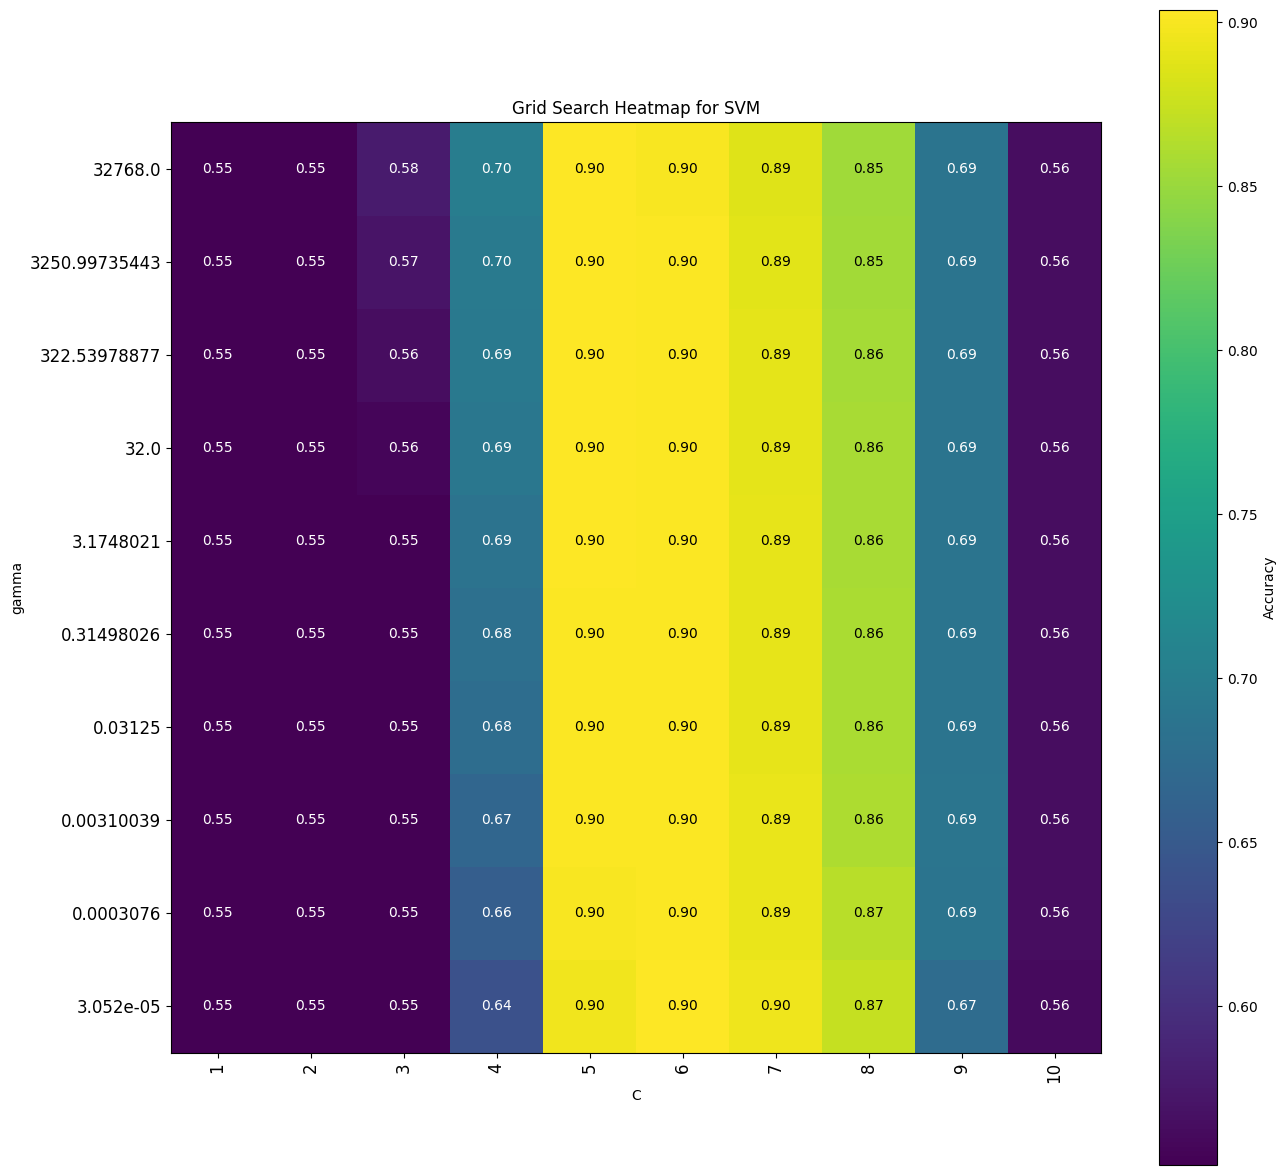

In [19]:
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(10, 10)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

res = heatmap(scores, "C", "gamma", param_grid['C'], np.round(param_grid['gamma'], 8), cmap="viridis", ax=ax)

plt.title("Grid Search Heatmap for SVM")

plt.colorbar(res, ax=ax, label="Accuracy")

plt.show()

- `C` between **5 and 7** appear to lead to a good model no matter the value of gamma.

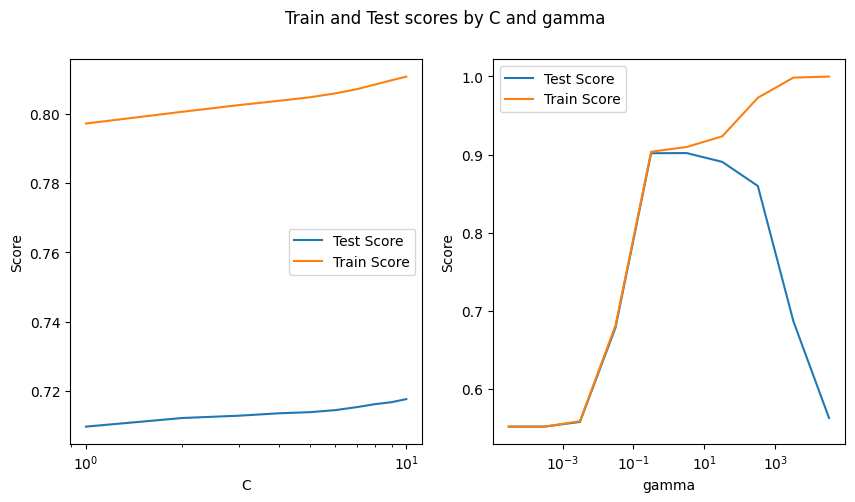

In [21]:
# plot train and test scores with markers by values of C and gamma
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# by C
ax[0].plot(param_grid['C'], results.groupby('param_C').mean_test_score.mean(), label='Test Score')
ax[0].plot(param_grid['C'], results.groupby('param_C').mean_train_score.mean(), label='Train Score')

# by gamma
ax[1].plot(param_grid['gamma'], results.groupby('param_gamma').mean_test_score.mean(), label='Test Score')
ax[1].plot(param_grid['gamma'], results.groupby('param_gamma').mean_train_score.mean(), label='Train Score')

ax[0].set_xscale('log')
ax[0].set_xlabel('C')
ax[0].set_ylabel('Score')
ax[0].legend(loc='best')

ax[1].set_xscale('log')
ax[1].set_xlabel('gamma')
ax[1].set_ylabel('Score')
ax[1].legend(loc='best')

plt.suptitle("Train and Test scores by C and gamma")
plt.show()